# Identification of DNA-binding motifs case study 

This section will present a comparative analysis to demonstrate the application and performance of proPythia for addressing sequence-based prediction problems.

We'll try to replicate the [Deep Learning in Genomics Primer Notebook](https://github.com/abidlabs/deep-learning-genomics-primer/blob/master/A_Primer_on_Deep_Learning_in_Genomics_Public.ipynb) which is a supplement to the manuscript [A Primer on Deep Learning in Genomics](https://www.nature.com/articles/s41588-018-0295-5).

In [1]:
%load_ext autoreload

import sys
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, matthews_corrcoef
from sklearn.preprocessing import StandardScaler

sys.path.append('../../../../src/')
from propythia.shallow_ml import ShallowML

from descriptors import DNADescriptor

In [2]:
dataset = pd.read_csv("dataset.csv")
print(dataset.shape)
print(dataset.head())

(2000, 2)
                                            sequence  label
0  CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...      0
1  GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...      0
2  GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...      0
3  GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGC...      1
4  GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATA...      1


<AxesSubplot:xlabel='label'>

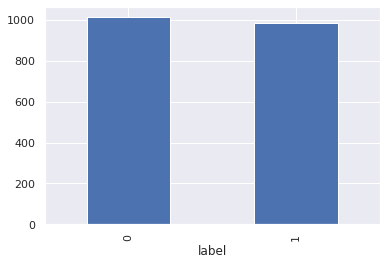

In [3]:
# plot the distribution of each class
dataset.groupby('label').size().plot(kind='bar')

In [4]:
# List of descriptors to be calculed. If empty, all descriptors will be calculated.
specifics = []

To calculate features, and to be more easy, we create a function to calculate features, calculating all available DNA features.
There are a total of 20 descriptors. They are: 
- length
- gc_content
- at_content
- nucleic_acid_composition
- enhanced_nucleic_acid_composition
- dinucleotide_composition
- trinucleotide_composition
- k_spaced_nucleic_acid_pairs
- kmer
- nucleotide_chemical_property
- accumulated_nucleotide_frequency
- DAC
- DCC
- DACC
- TAC
- TCC
- TACC
- PseDNC
- PseKNC
- binary

In [5]:
def calculate_feature(data):
    list_feature = []
    count = 0
    for seq in data['sequence']:
        res = {'sequence': seq}
        dna = DNADescriptor(seq)
        feature = dna.get_descriptors(specifics=specifics)
        res.update(feature)
        list_feature.append(res)
        
        # print progress every 100 sequences
        if count % 100 == 0:
            print(count, '/', len(data))

        count += 1
    print("Done!")
    df = pd.DataFrame(list_feature)
    return df

features = calculate_feature(dataset)

0 / 2000
100 / 2000
200 / 2000
300 / 2000
400 / 2000
500 / 2000
600 / 2000
700 / 2000
800 / 2000
900 / 2000
1000 / 2000
1100 / 2000
1200 / 2000
1300 / 2000
1400 / 2000
1500 / 2000
1600 / 2000
1700 / 2000
1800 / 2000
1900 / 2000
Done!


In [6]:
fps_y = dataset['label']
fps_x = features.loc[:, features.columns != 'label']
fps_x = fps_x.loc[:, fps_x.columns != 'sequence']

In [7]:
no_need_normalization = ["length", "at_content", "gc_content"]

need_dict_normalization = ["nucleic_acid_composition", "enhanced_nucleic_acid_composition","dinucleotide_composition","trinucleotide_composition","k_spaced_nucleic_acid_pairs","kmer","PseDNC", "PseKNC"]

need_list_normalization = ["nucleotide_chemical_property", "accumulated_nucleotide_frequency", "DAC", "DCC", "DACC", "TAC","TCC","TACC", "binary"]

def normalize_dict(d, field):
    df = pd.json_normalize(d)
    df.columns = [str(field) + "_" + str(i) for i in df.columns]
    
    for f in df.columns:
        if isinstance(df[f][0], dict):
            df = pd.concat([df, normalize_dict(df[f], f)], axis=1)
            df.drop(f, axis=1, inplace=True)
    return df

def normalize_list(l, field):
    df = pd.DataFrame(l.to_list())
    df.columns = [str(field) + "_" + str(i) for i in df.columns]
    
    for f in df.columns:
        if isinstance(df[f][0], list):
            df = pd.concat([df, normalize_list(df[f], f)], axis=1)
            df.drop(f, axis=1, inplace=True)
    return df

new_fps_x = pd.DataFrame()

for col in fps_x.columns:
    if col in need_dict_normalization:
        new_fps_x = pd.concat([new_fps_x, normalize_dict(fps_x[col], col)], axis=1)
    elif col in need_list_normalization:
        new_fps_x = pd.concat([new_fps_x, normalize_list(fps_x[col], col)], axis=1)
    else:
        new_fps_x[col] = fps_x[col].to_numpy()
        
new_fps_x

,length,gc_content,at_content,nucleic_acid_composition_A,nucleic_acid_composition_C,nucleic_acid_composition_G,nucleic_acid_composition_T,enhanced_nucleic_acid_composition_0_A,enhanced_nucleic_acid_composition_0_C,enhanced_nucleic_acid_composition_0_G,...,binary_47_2,binary_47_3,binary_48_0,binary_48_1,binary_48_2,binary_48_3,binary_49_0,binary_49_1,binary_49_2,binary_49_3
0,50,0.60,0.40,0.18,0.26,0.34,0.22,0.2,0.4,0.4,...,0,0,0,1,0,0,0,1,0,0
1,50,0.48,0.52,0.12,0.16,0.32,0.40,0.2,0.0,0.4,...,0,1,0,1,0,0,0,0,1,0
2,50,0.54,0.46,0.34,0.26,0.28,0.12,0.4,0.2,0.2,...,0,0,0,1,0,0,0,0,0,1
3,50,0.64,0.36,0.24,0.42,0.22,0.12,0.2,0.4,0.2,...,0,0,0,0,0,1,0,0,1,0
4,50,0.54,0.46,0.28,0.26,0.28,0.18,0.2,0.2,0.6,...,1,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,50,0.66,0.34,0.16,0.26,0.40,0.18,0.0,0.4,0.4,...,1,0,1,0,0,0,0,0,1,0
1996,50,0.44,0.56,0.22,0.22,0.22,0.34,0.0,0.2,0.4,...,0,1,0,1,0,0,0,0,0,1
1997,50,0.46,0.54,0.18,0.24,0.22,0.36,0.2,0.4,0.2,...,0,0,0,1,0,0,0,0,0,1
1998,50,0.48,0.52,0.28,0.24,0.24,0.24,0.4,0.2,0.2,...,1,0,1,0,0,0,1,0,0,0


In [8]:
X_train, X_test, y_train, y_test = train_test_split(new_fps_x, fps_y, stratify=fps_y)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

ml = ShallowML(X_train, X_test, y_train, y_test, report_name=None, columns_names=new_fps_x.columns)

param_grid = [{'clf__n_estimators': [100, 250, 500, 750], 'clf__max_features': ['sqrt']}]

best_rf_model_enhancers = ml.train_best_model(
    model_name=None,
    model='rf',
    score=make_scorer(matthews_corrcoef),
    param_grid=param_grid,
    cv=10
)

performing gridSearch...
GridSearchCV took 10.48 seconds for 4 candidate parameter settings.
GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scl', None),
                                       ('clf',
                                        RandomForestClassifier(random_state=1))]),
             n_jobs=10,
             param_grid=[{'clf__max_features': ['sqrt'],
                          'clf__n_estimators': [100, 250, 500, 750]}],
             scoring=make_scorer(matthews_corrcoef))
Model with rank: 1
 Mean validation score: 0.988 (std: 0.011)
 Parameters: {'clf__max_features': 'sqrt', 'clf__n_estimators': 500}
 

Model with rank: 2
 Mean validation score: 0.988 (std: 0.013)
 Parameters: {'clf__max_features': 'sqrt', 'clf__n_estimators': 750}
 

Model with rank: 3
 Mean validation score: 0.987 (std: 0.013)
 Parameters: {'clf__max_features': 'sqrt', 'clf__n_estimators': 250}
 

make_scorer(matthews_corrcoef)
10
Best score (scorer: make_scorer(matthews_corrcoef)) and parame

In [9]:
scores, report, cm, cm2 = ml.score_testset(best_rf_model_enhancers)
print(report)
print(cm)  
scores

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       253
           1       0.99      0.99      0.99       247

    accuracy                           0.99       500
   macro avg       0.99      0.99      0.99       500
weighted avg       0.99      0.99      0.99       500

[[250   3]
 [  2 245]]


{'Accuracy': 0.99,
 'MCC': 0.9800059213999118,
 'log_loss': 0.08747214823136405,
 'f1 score': 0.98989898989899,
 'roc_auc': 0.9900225632491079,
 'Precision': array([0.494     , 0.98790323, 1.        ]),
 'Recall': array([1.        , 0.99190283, 0.        ]),
 'fdr': 0.012096774193548387,
 'sn': 0.9919028340080972,
 'sp': 0.9881422924901185}